# Présentation POC framework covid19

4 fonctionnalités :
- transparence
- aider à la communication y compris pour des non data-scientist
- reproductibilité
- fonctionnement "open"

# Import

In [1]:
import pandas as pd
import numpy as np

import os, sys
# Adding parent directory to python path
sys.path.append(os.path.dirname(os.getcwd()))

import ml_workflow
from ml_workflow.rule import Rule, rule

import sqlite3

# Pseudo covid 19

In [2]:
personnal_data_file = 'data/train.csv'
pcr_tests_db = 'data/pcr_tests.db'
consultation_db = 'data/consultations.db'


@ml_workflow.mlwf_data_source(name='Personnal data csv file')
def retrieve_personnal_data():
    return pd.read_csv(personnal_data_file)

@ml_workflow.mlwf_data_source(name='Retrieve pcr tests')
def retrieve_pcr_tests():
    conn = sqlite3.connect(pcr_tests_db)
    return pd.read_sql(
        'SELECT id, person_id, pcr_result, test_date FROM pcr_test ORDER BY id',
        conn
    )

@ml_workflow.mlwf_data_source(name='Retrieve data source')
def retrieve_visites():
    conn = sqlite3.connect(consultation_db)
    return pd.read_sql(
        'SELECT id, person_id, services, hospital, consultation_date FROM consultations ORDER BY id',
        conn
    )


    

@rule(name='select_with_age', highlight=2)
def select_with_age(personnal_df):
    return personnal_df[np.logical_not(personnal_df['age'].isna())]
        
def get_patients_status():
    personnal_df = retrieve_personnal_data()
    print(personnal_df.ml_workflow_current_node.origin)
    
    personnal_df = Rule.call_from_reference_name('select_with_age')(personnal_df)
        
    return personnal_df

def get_patients_pcr_positives():
    patient_status = get_patients_status()
    
    tests_pcr = retrieve_pcr_tests()
    
    with Rule(name='pcr positif'):
        tests_pcr = tests_pcr[tests_pcr['pcr_result'] == 'positive']
    
    with Rule(name='pcr_positif_merge'):
        return patient_status.merge(tests_pcr, left_on='id', right_on='person_id')
    
def get_consultations():
    return retrieve_visites()


## Sqlite3 play-ground

## Pandas play-ground

In [3]:
get_patients_status()['age'].mean()

Personnal data csv file


29.6206862745098

# User code

Personnal data csv file


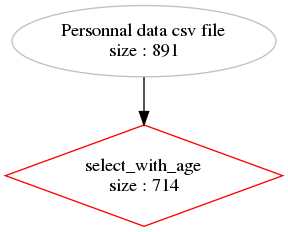

In [4]:
patient_status = get_patients_status()

patient_status.plot_model()

Personnal data csv file


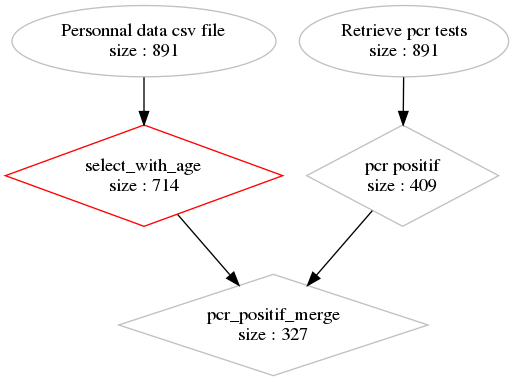

In [5]:
get_patients_pcr_positives().plot_model()

Personnal data csv file


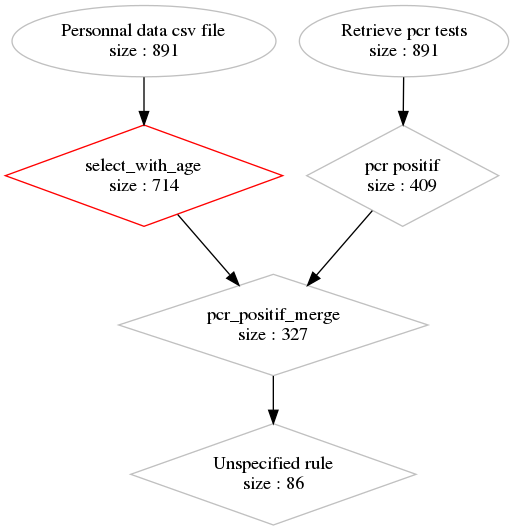

In [6]:
patients = get_patients_pcr_positives()

my_patient_status = patients[patients['age'] >= 18]
my_patient_status = my_patient_status[my_patient_status['sex'] == 'female']

my_patient_status.plot_model('graph.svg')
my_patient_status.plot_model()


Personnal data csv file


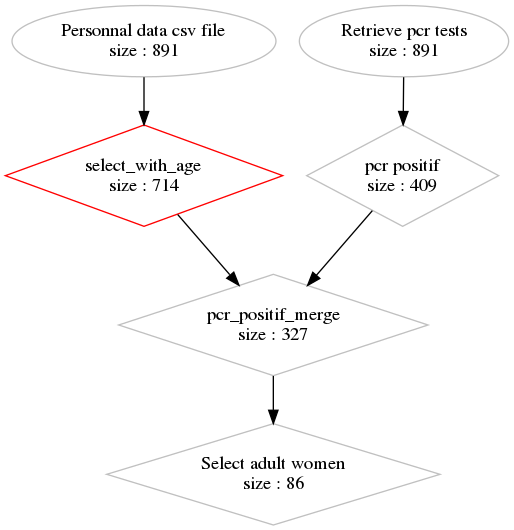

In [7]:
patients = get_patients_pcr_positives()

with Rule(name='Select adult women'):
    my_patient_status = patients[patients['age'] >= 18]
    my_patient_status = my_patient_status[my_patient_status['sex'] == 'female']

my_patient_status.plot_model('graph.png')

# Fonctionnalité reproductibilité

In [8]:
conn = sqlite3.connect(pcr_tests_db)
conn.execute("UPDATE pcr_test SET pcr_result = 'positive' WHERE pcr_result = 'Positif'")
conn.commit()

Personnal data csv file
Nb patients : 327
Personnal data csv file
Nb patients : 0


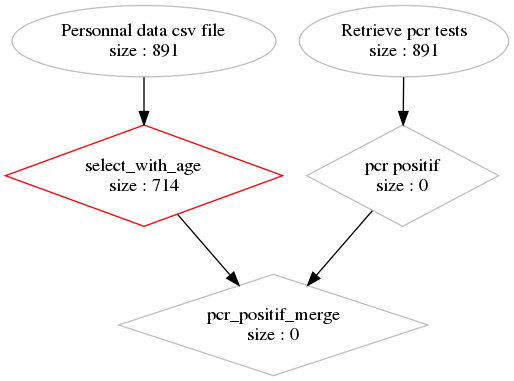

In [9]:
from ml_workflow.session import Session   
    


with Session.record_data_source('temp/test_session_record'):
    patients = get_patients_pcr_positives()

print(f"Nb patients : {len(patients)}")

conn = sqlite3.connect(pcr_tests_db)
conn.execute("UPDATE pcr_test SET pcr_result = 'Positif' WHERE pcr_result = 'positive'")
conn.commit()

patients = get_patients_pcr_positives()
print(f"Nb patients : {len(patients)}")

patients.plot_model('graph.png')

In [10]:
with Session.play_data_source_record('temp/test_session_record'):
    patients = get_patients_pcr_positives()
    
print(f"Nb patients : {len(patients)}")

Personnal data csv file
Nb patients : 327


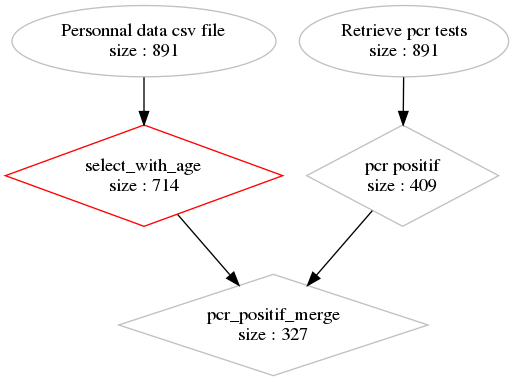

In [11]:
patients.plot_model()

## Cleaning db for the other cells

In [12]:
conn = sqlite3.connect(pcr_tests_db)
conn.execute("UPDATE pcr_test SET pcr_result = 'positive' WHERE pcr_result = 'Positif'")
conn.commit()

# Fonctionnalité versionning

Personnal data csv file


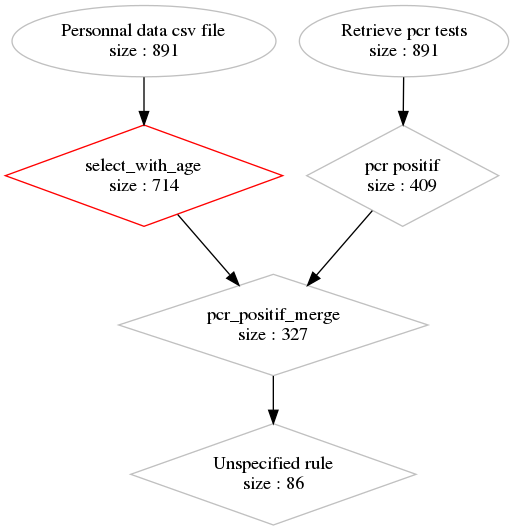

In [13]:
patients = get_patients_pcr_positives()

my_patient_status = patients[patients['age'] >= 18]
my_patient_status = my_patient_status[my_patient_status['sex'] == 'female']

my_patient_status.plot_model('graph.png')

# Fonctionnalité de choix de version de règles

Personnal data csv file


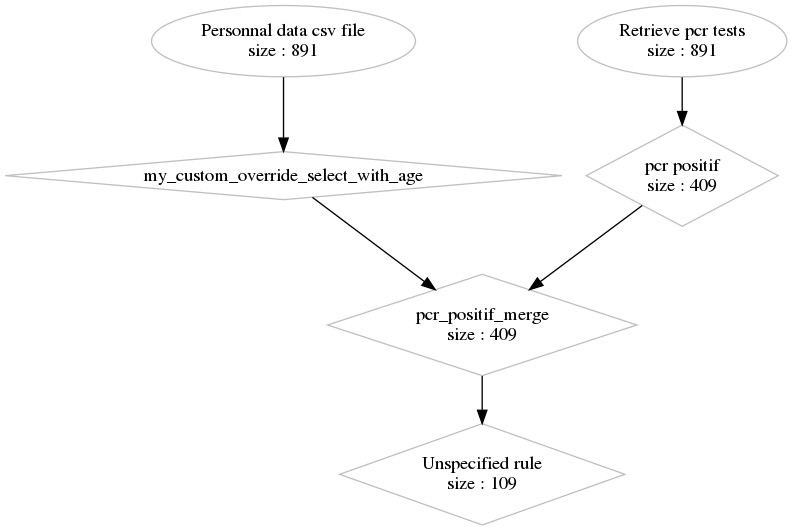

In [14]:
@rule(name='my_custom_override_select_with_age')
def my_custom_override_select_with_age(df):
    df.loc[df['age'].isna(), 'age'] = df['age'].mean()
    
    return df

Rule.set_for_reference_name('select_with_age', my_custom_override_select_with_age)

patients = get_patients_pcr_positives()

my_patient_status = patients[patients['age'] >= 18]
my_patient_status = my_patient_status[my_patient_status['sex'] == 'female']

my_patient_status.plot_model('graph.png')

In [15]:
Rule.unset_for_reference_name('select_with_age')